In [66]:
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
from folium import plugins 
import scipy.stats
from datetime import datetime

In [2]:
#Importing data
derecho_calls = pd.read_csv('../data/911_Phone Calls_Derecho_050320_050420.csv')
tornado_calls = pd.read_csv('../data/911_Phone_Calls_Tornado_030320.csv')
derecho_dispatch = pd.read_csv('../data/Computer Aided Dispatch Data_Derecho Incidents 050320-050420.csv', skiprows = 2)
tornado_dispatch = pd.read_csv('../data/Computer Aided Dispatch Data_Tornado Incidents 030320.csv', skiprows = 2)
damage_points = gpd.read_file('../data/damage_points.geojson')
path_polygons = gpd.read_file('../data/path_polygons.geojson')
tornado_paths = gpd.read_file('../data/tornado_paths.geojson')
calls_2020 = pd.read_csv('../data/2020_calls.csv')

In [3]:
#Dropping superfluous columns
derecho_calls = derecho_calls.drop('CallTypeId', 1)
tornado_calls = tornado_calls.drop('CallTypeId', 1)
calls_2020 = calls_2020[['time', 'tencode', 'disposition']]

C:\Users\apcsm\AppData\Local\Temp/ipykernel_7292/2564426903.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  derecho_calls = derecho_calls.drop('CallTypeId', 1)
C:\Users\apcsm\AppData\Local\Temp/ipykernel_7292/2564426903.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  tornado_calls = tornado_calls.drop('CallTypeId', 1)


In [4]:
#Renaming columns
derecho_calls.columns = ['time', 'lat', 'lng', 'cell_tower_add']
tornado_calls.columns = ['time', 'lat', 'lng', 'cell_tower_add']
derecho_dispatch.columns = ['time', 'location', 'lat', 'lng', 'desc']
tornado_dispatch.columns = ['time', 'location', 'lat', 'lng', 'desc']

In [5]:
#Creating a geometry column for the csv files
derecho_calls['geometry'] = derecho_calls.apply(lambda x: Point((float(x.lng), float(x.lat))), axis = 1)
tornado_calls['geometry'] = tornado_calls.apply(lambda x: Point((float(x.lng), float(x.lat))), axis = 1)
derecho_dispatch['geometry'] = derecho_dispatch.apply(lambda x: Point((float(x.lng), float(x.lat))), axis = 1)
tornado_dispatch['geometry'] = tornado_dispatch.apply(lambda x: Point((float(x.lng), float(x.lat))), axis = 1)

In [6]:
#Creating geodataframes from csv files
derecho_calls_geo = gpd.GeoDataFrame(derecho_calls, crs = damage_points.crs, geometry = derecho_calls['geometry'])
tornado_calls_geo = gpd.GeoDataFrame(tornado_calls, crs = damage_points.crs, geometry = tornado_calls['geometry'])
derecho_dispatch_geo = gpd.GeoDataFrame(derecho_dispatch, crs = damage_points.crs, geometry = derecho_dispatch['geometry'])
tornado_dispatch_geo = gpd.GeoDataFrame(tornado_dispatch, crs = damage_points.crs, geometry = tornado_dispatch['geometry'])

In [7]:
#Changing time to a military format
derecho_calls_geo.time = pd.to_datetime(derecho_calls_geo.time)
tornado_calls_geo.time = pd.to_datetime(tornado_calls_geo.time)
derecho_dispatch_geo.time = pd.to_datetime(derecho_dispatch_geo.time)
tornado_dispatch_geo.time = pd.to_datetime(tornado_dispatch_geo.time)
calls_2020.time = pd.to_datetime(calls_2020.time)

In [8]:
#Creating geodataframes with NAs dropped
derecho_calls_geo_dropna = derecho_calls_geo.dropna()
tornado_calls_geo_dropna = tornado_calls_geo.dropna()

In [9]:
#Pulling out lat and lng data from damage_points df (for use with heatmapping points)
damage_points['lat'] = damage_points.geometry.y
damage_points['lng'] = damage_points.geometry.x

In [40]:
#Creating a weekday column for calls 2020, and changing the numberic values there to strings
calls_2020['weekday'] = calls_2020.time.dt.dayofweek
weekdays = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday',6:'Sunday'}
calls_2020.weekday = calls_2020.weekday.replace(weekdays)

<AxesSubplot:>

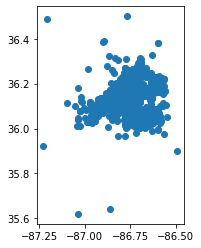

In [10]:
derecho_calls_geo.plot()

<AxesSubplot:>

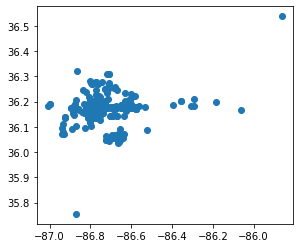

In [11]:
tornado_calls_geo.plot()

<AxesSubplot:>

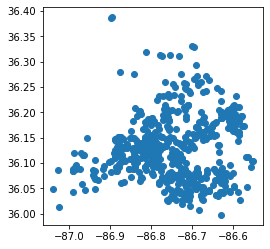

In [12]:
derecho_dispatch_geo.plot()

<AxesSubplot:>

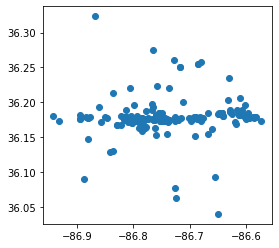

In [13]:
tornado_dispatch_geo.plot()

<AxesSubplot:>

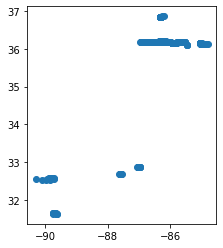

In [14]:
damage_points.plot()

<AxesSubplot:>

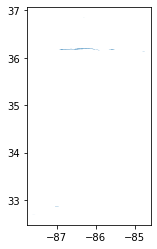

In [15]:
path_polygons.plot()

<AxesSubplot:>

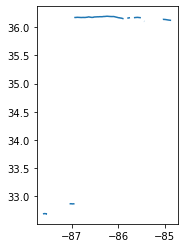

In [16]:
tornado_paths.plot()

In [17]:
map = folium.Map(location = [36.134256, -86.822034], zoom_start = 10)

#folium.GeoJson(damage_points).add_to(map)

#folium.GeoJson(path_polygons).add_to(map)

#folium.GeoJson(tornado_paths, style_function = lambda x: {'color':'#ffc183', 'fillcolor':'#ffc183'}).add_to(map)

damageArr = damage_points[['lat','lng']].values
map.add_child(plugins.HeatMap(damageArr, radius = 15))

map

In [18]:
map = folium.Map(location = [36.134256, -86.822034], zoom_start = 10) 

#Note I subset the dfs because the 'time' column being in a time format gives an error when we try to plot the points- I 
#just temporarily remove the 'time' column to get around this.


#folium.GeoJson(derecho_calls_geo_dropna[['lat', 'lng', 'cell_tower_add', 'geometry']]).add_to(map) 

#folium.GeoJson(tornado_calls_geo_dropna[['lat','lng','cell_tower_add','geometry']]).add_to(map)

#folium.GeoJson(derecho_dispatch_geo[['location', 'lat', 'lng', 'desc', 'geometry']]).add_to(map)

#folium.GeoJson(tornado_dispatch_geo[['location', 'lat', 'lng', 'desc', 'geometry']]).add_to(map)


map

In [19]:
#Tornado 911 calls, dispatches, and tornado path
map = folium.Map(location = [36.134256, -86.822034], zoom_start = 10)

for row_index, row_values in tornado_calls_geo_dropna.iterrows():
    loc = [row_values['lat'], row_values['lng']]
    pop = str(row_values['cell_tower_add'])
    
    marker = folium.CircleMarker(location = loc, radius = 1, popup = pop, weight = 3, color = 'red')
    
    marker.add_to(map)

for row_index, row_values in tornado_dispatch_geo.iterrows():
    loc = [row_values['lat'], row_values['lng']]
    pop = str(row_values['desc'])
    
    marker = folium.CircleMarker(location = loc, radius = 1, popup = pop, weight = 3, color = 'green')
    
    marker.add_to(map)

#folium.GeoJson(path_polygons, style_function = lambda x: {'color': '#000000'}).add_to(map)

map


In [20]:
#Derecho 911 calls and dispatches 
map = folium.Map(location = [36.134256, -86.822034], zoom_start = 10)

for row_index, row_values in derecho_calls_geo_dropna.iterrows():
    loc = [row_values['lat'], row_values['lng']]
    pop = str(row_values['cell_tower_add'])
    
    marker = folium.CircleMarker(location = loc, radius = 1, popup = pop, weight = 2, color = 'red')
    
    marker.add_to(map)


for row_index, row_values in derecho_dispatch_geo.iterrows():
    loc = [row_values['lat'], row_values['lng']]
    pop = str(row_values['desc'])
    
    marker = folium.CircleMarker(location = loc, radius = 1, popup = pop, weight = 2, color = 'black')
    
    marker.add_to(map)
    
map

## 1. Develop a timeline of each storm based on the call locations and volume. This can include the following:
#### - Beginning and end of the event, based on call times
#### - Times of stronger storm impacts, based on call volumes


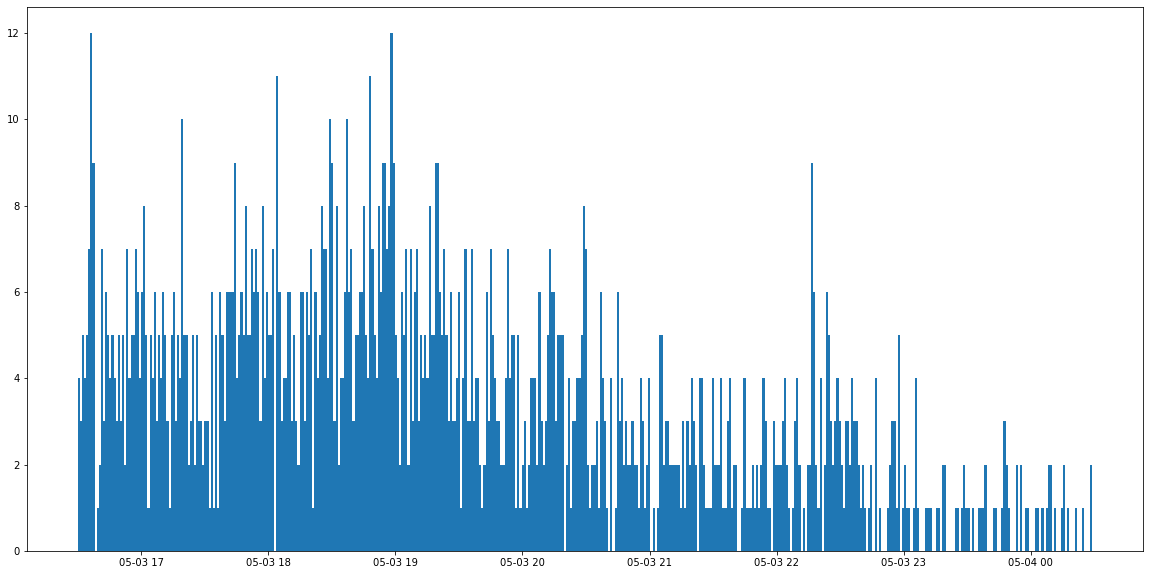

In [31]:
#Derecho call frequency using derecho_calls data
plt.figure(figsize = (20, 10))
plt.hist(derecho_calls_geo.time, bins = 480); #479 is the number of minutes from the first to last call of this dataset

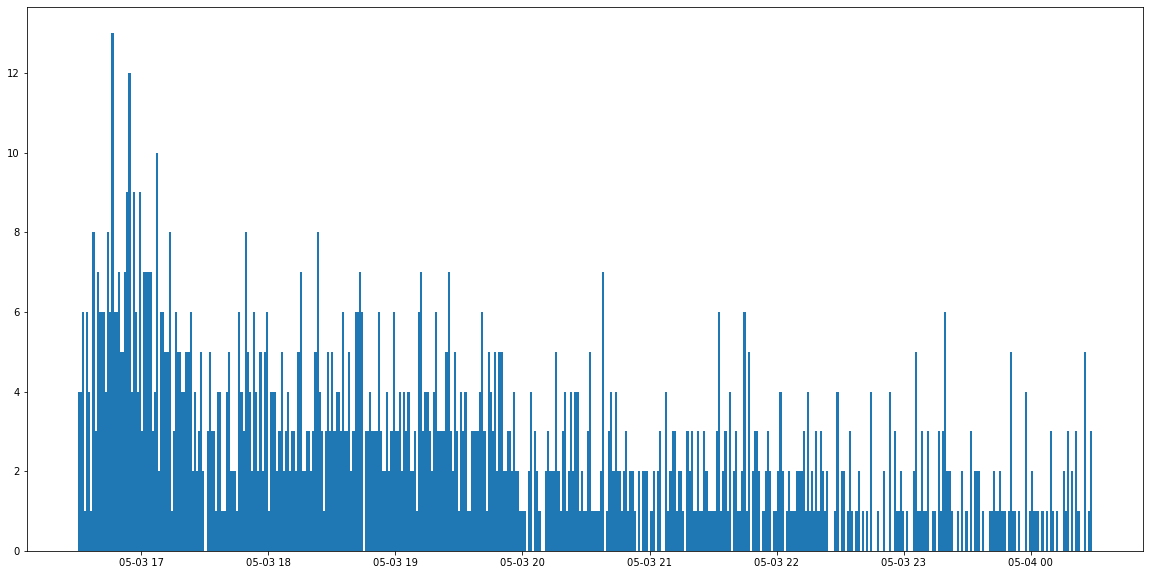

In [29]:
#Derecho calls frequency using calls_2020 data
plt.figure(figsize = (20, 10))
plt.hist(calls_2020.time.loc[(calls_2020.time >= pd.to_datetime('2020-05-03 16:30:00')) & (calls_2020.time < pd.to_datetime('2020-05-04 00:30:00'))], bins = 480);

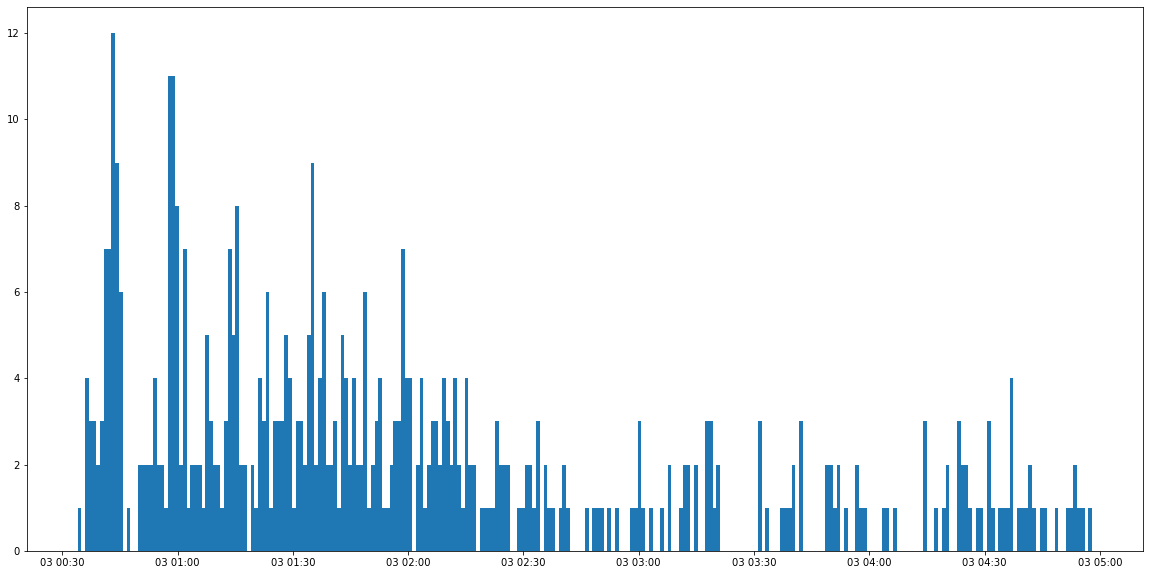

In [32]:
#Tornado calls frequency using tornado_calls data
plt.figure(figsize = (20, 10))
plt.hist(tornado_calls_geo.time, bins = 270); #254 is the number of minutes from the first to last call of this dataset.

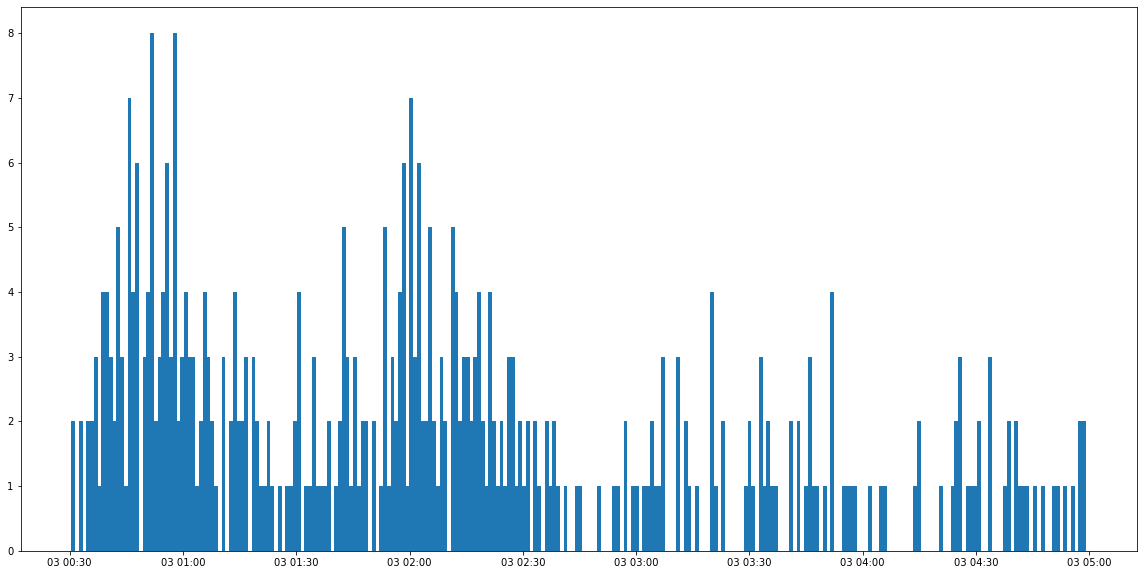

In [30]:
#Tornado calls frequency using calls_2020 data
plt.figure(figsize = (20, 10))
plt.hist(calls_2020.time.loc[(calls_2020.time >= pd.to_datetime('2020-03-03 00:30:00')) & (calls_2020.time < pd.to_datetime('2020-03-03 05:00:00'))], bins = 270);

In [101]:
sunday_calls_2020 = calls_2020.loc[calls_2020.weekday == 'Sunday']
monday_calls_2020 = calls_2020.loc[calls_2020.weekday == 'Monday']
tuesday_calls_2020 = calls_2020.loc[calls_2020.weekday == 'Tuesday']

In [ ]:
sunday_calls_2020['time'] = sunday_calls_2020['time'].astype(str)
monday_calls_2020['time'] = monday_calls_2020['time'].astype(str)
tuesday_calls_2020['time'] = tuesday_calls_2020['time'].astype(str)

In [103]:
sunday_calls_2020['time'] = sunday_calls_2020.time.str[11:]
monday_calls_2020['time'] = monday_calls_2020.time.str[11:]
tuesday_calls_2020['time'] = tuesday_calls_2020.time.str[11:]

C:\Users\apcsm\AppData\Local\Temp/ipykernel_7292/3436216263.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sunday_calls_2020['time'] = sunday_calls_2020.time.str[11:]
C:\Users\apcsm\AppData\Local\Temp/ipykernel_7292/3436216263.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monday_calls_2020['time'] = monday_calls_2020.time.str[11:]
C:\Users\apcsm\AppData\Local\Temp/ipykernel_7292/3436216263.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [109]:
sunday_calls_2020.time = pd.to_datetime(sunday_calls_2020.time)
monday_calls_2020.time = pd.to_datetime(monday_calls_2020.time)
tuesday_calls_2020.time = pd.to_datetime(tuesday_calls_2020.time)

C:\Users\apcsm\Anaconda3\envs\geospatial\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [110]:
#Avg sunday call frequency, using calls_2020 data
plt.figure(figsize = (20, 10
plt.hist(sunday_calls_2020.time.loc[(sunday_calls_2020.time >= pd.to_datetime('2020-11-08 16:30:00')) & (sunday_calls_2020.time < pd.to_datetime('2020-11-08 00:30:00'))], bins = 480);

SyntaxError: invalid syntax (Temp/ipykernel_7292/1706423022.py, line 3)

In [105]:
derecho_calls_geo.time = pd.to_datetime(derecho_calls_geo.time)

time           object
tencode        object
disposition    object
weekday        object
dtype: object

In [ ]:
#Tornado 911 calls and tornado path
map = folium.Map(location = [36.134256, -86.822034], zoom_start = 10)

for row_index, row_values in tornado_calls_geo_dropna.iterrows():
    loc = [row_values['lat'], row_values['lng']]
    pop = str(row_values['cell_tower_add'])
    if row_values['time'] < pd.to_datetime('2020-03-03 01:00:00'):
        color = '#261a19'
    elif row_values['time'] < pd.to_datetime('2020-03-03 01:30:00'):
        color = '#3f2924'
    elif row_values['time'] < pd.to_datetime('2020-03-03 02:00:00'):
        color = '#663d30'
    elif row_values['time'] < pd.to_datetime('2020-03-03 02:30:00'):
        color = '#90573b'
    elif row_values['time'] < pd.to_datetime('2020-03-03 03:00:00'):
        color = '#c27945'
    elif row_values['time'] < pd.to_datetime('2020-03-03 03:30:00'):
        color = '#e7af64'
    elif row_values['time'] < pd.to_datetime('2020-03-03 04:00:00'):
        color = '#f4d692'
    elif row_values['time'] < pd.to_datetime('2020-03-03 04:30:00'):
        color = '#f3e8c4'
    
    marker = folium.CircleMarker(location = loc, radius = 1, popup = pop, weight = 3, color = color)
    
    marker.add_to(map)

folium.GeoJson(path_polygons, style_function = lambda x: {'color': 'lightblue'}).add_to(map)

map


In [ ]:
#Heatmap of all 911 tornado calls
map = folium.Map(location = [36.134256, -86.822034], zoom_start = 10)

tornadocallArr = tornado_calls_geo_dropna[['lat', 'lng']].values
map.add_child(plugins.HeatMap(tornadocallArr, radius = 15))

map

In [ ]:
map = folium.Map(location = [36.134256, -86.822034], zoom_start = 10)

tornadocallArr = (tornado_calls_geo_dropna.loc[tornado_calls_geo_dropna.time < pd.to_datetime('2020-03-03 01:00:00')])[['lat', 'lng']].values
map.add_child(plugins.HeatMap(tornadocallArr, radius = 15))

map

In [ ]:
map = folium.Map(location = [36.134256, -86.822034], zoom_start = 10)

tornadocallArr = tornado_calls_geo_dropna.loc[(tornado_calls_geo_dropna.time >= pd.to_datetime('2020-03-03 01:00:00')) & (tornado_calls_geo_dropna.time < pd.to_datetime('2020-03-03 01:30:00'))][['lat', 'lng']].values
map.add_child(plugins.HeatMap(tornadocallArr, radius = 15))

map

In [ ]:
map = folium.Map(location = [36.134256, -86.822034], zoom_start = 10)

tornadocallArr = tornado_calls_geo_dropna.loc[(tornado_calls_geo_dropna.time >= pd.to_datetime('2020-03-03 01:30:00')) & (tornado_calls_geo_dropna.time < pd.to_datetime('2020-03-03 02:00:00'))][['lat', 'lng']].values
map.add_child(plugins.HeatMap(tornadocallArr, radius = 15))

map

In [ ]:
map = folium.Map(location = [36.134256, -86.822034], zoom_start = 10)

tornadocallArr = tornado_calls_geo_dropna.loc[(tornado_calls_geo_dropna.time >= pd.to_datetime('2020-03-03 02:00:00')) & (tornado_calls_geo_dropna.time < pd.to_datetime('2020-03-03 02:30:00'))][['lat', 'lng']].values
map.add_child(plugins.HeatMap(tornadocallArr, radius = 15))

map

In [ ]:
map = folium.Map(location = [36.134256, -86.822034], zoom_start = 10)

tornadocallArr = tornado_calls_geo_dropna.loc[(tornado_calls_geo_dropna.time >= pd.to_datetime('2020-03-03 02:30:00')) & (tornado_calls_geo_dropna.time < pd.to_datetime('2020-03-03 03:00:00'))][['lat', 'lng']].values
map.add_child(plugins.HeatMap(tornadocallArr, radius = 15))

map

In [ ]:
map = folium.Map(location = [36.134256, -86.822034], zoom_start = 10)

tornadocallArr = tornado_calls_geo_dropna.loc[(tornado_calls_geo_dropna.time >= pd.to_datetime('2020-03-03 03:00:00')) & (tornado_calls_geo_dropna.time < pd.to_datetime('2020-03-03 03:30:00'))][['lat', 'lng']].values
map.add_child(plugins.HeatMap(tornadocallArr, radius = 15))

map

In [ ]:
map = folium.Map(location = [36.134256, -86.822034], zoom_start = 10)

tornadocallArr = tornado_calls_geo_dropna.loc[(tornado_calls_geo_dropna.time >= pd.to_datetime('2020-03-03 03:30:00')) & (tornado_calls_geo_dropna.time < pd.to_datetime('2020-03-03 04:00:00'))][['lat', 'lng']].values
map.add_child(plugins.HeatMap(tornadocallArr, radius = 15))

map

In [ ]:
map = folium.Map(location = [36.134256, -86.822034], zoom_start = 10)

tornadocallArr = tornado_calls_geo_dropna.loc[(tornado_calls_geo_dropna.time >= pd.to_datetime('2020-03-03 04:00:00')) & (tornado_calls_geo_dropna.time < pd.to_datetime('2020-03-03 04:30:00'))][['lat', 'lng']].values
map.add_child(plugins.HeatMap(tornadocallArr, radius = 15))

map

In [ ]:
map = folium.Map(location = [36.134256, -86.822034], zoom_start = 10)

tornadocallArr = tornado_calls_geo_dropna.loc[(tornado_calls_geo_dropna.time >= pd.to_datetime('2020-03-03 04:30:00')) & (tornado_calls_geo_dropna.time < pd.to_datetime('2020-03-03 05:00:00'))][['lat', 'lng']].values
map.add_child(plugins.HeatMap(tornadocallArr, radius = 15))

map

In [ ]:
#Heatmap of all 911 derecho calls
map = folium.Map(location = [36.134256, -86.822034], zoom_start = 10)

derechocallArr = derecho_calls_geo_dropna[['lat', 'lng']].values
map.add_child(plugins.HeatMap(derechocallArr, radius = 15))

map

In [ ]:
map = folium.Map(location = [36.134256, -86.822034], zoom_start = 10)

derechocallArr = derecho_calls_geo_dropna[derecho_calls_geo_dropna.time < pd.to_datetime('2020-05-03 17:30:00')][['lat', 'lng']].values
map.add_child(plugins.HeatMap(derechocallArr, radius = 15))

map

In [ ]:
map = folium.Map(location = [36.134256, -86.822034], zoom_start = 10)

derechocallArr = derecho_calls_geo_dropna[(derecho_calls_geo_dropna.time >= pd.to_datetime('2020-05-03 17:30:00')) & (derecho_calls_geo_dropna.time < pd.to_datetime('2020-05-03 18:30:00'))][['lat', 'lng']].values
map.add_child(plugins.HeatMap(derechocallArr, radius = 15))

map

In [ ]:
map = folium.Map(location = [36.134256, -86.822034], zoom_start = 10)

derechocallArr = derecho_calls_geo_dropna[(derecho_calls_geo_dropna.time >= pd.to_datetime('2020-05-03 18:30:00')) & (derecho_calls_geo_dropna.time < pd.to_datetime('2020-05-03 19:30:00'))][['lat', 'lng']].values
map.add_child(plugins.HeatMap(derechocallArr, radius = 15))

map

In [ ]:
map = folium.Map(location = [36.134256, -86.822034], zoom_start = 10)

derechocallArr = derecho_calls_geo_dropna[(derecho_calls_geo_dropna.time >= pd.to_datetime('2020-05-03 19:30:00')) & (derecho_calls_geo_dropna.time < pd.to_datetime('2020-05-03 20:30:00'))][['lat', 'lng']].values
map.add_child(plugins.HeatMap(derechocallArr, radius = 15))

map

In [ ]:
map = folium.Map(location = [36.134256, -86.822034], zoom_start = 10)

derechocallArr = derecho_calls_geo_dropna[(derecho_calls_geo_dropna.time >= pd.to_datetime('2020-05-03 20:30:00')) & (derecho_calls_geo_dropna.time < pd.to_datetime('2020-05-03 21:30:00'))][['lat', 'lng']].values
map.add_child(plugins.HeatMap(derechocallArr, radius = 15))

map

In [ ]:
map = folium.Map(location = [36.134256, -86.822034], zoom_start = 10)

derechocallArr = derecho_calls_geo_dropna[(derecho_calls_geo_dropna.time >= pd.to_datetime('2020-05-03 21:30:00')) & (derecho_calls_geo_dropna.time < pd.to_datetime('2020-05-03 22:30:00'))][['lat', 'lng']].values
map.add_child(plugins.HeatMap(derechocallArr, radius = 15))

map

In [ ]:
map = folium.Map(location = [36.134256, -86.822034], zoom_start = 10)

derechocallArr = derecho_calls_geo_dropna[(derecho_calls_geo_dropna.time >= pd.to_datetime('2020-05-03 22:30:00')) & (derecho_calls_geo_dropna.time < pd.to_datetime('2020-05-03 23:30:00'))][['lat', 'lng']].values
map.add_child(plugins.HeatMap(derechocallArr, radius = 15))

map

In [ ]:
map = folium.Map(location = [36.134256, -86.822034], zoom_start = 10)

derechocallArr = derecho_calls_geo_dropna[(derecho_calls_geo_dropna.time >= pd.to_datetime('2020-05-03 23:30:00')) & (derecho_calls_geo_dropna.time < pd.to_datetime('2020-06-03 00:30:00'))][['lat', 'lng']].values
map.add_child(plugins.HeatMap(derechocallArr, radius = 15))

map